>[Trabajo Práctico 3: selección de modelo](#scrollTo=tb40sRputoKy)

>[0. Introducción](#scrollTo=Dd5Yq97Ut0Ot)

>[I. Modelado](#scrollTo=xxoJg-55uQgm)

>>[1. Modelo Baseline](#scrollTo=kwHf1nTf1W7Q)

>>[2. Modelos con Logistic Regression](#scrollTo=nlfgrMXb1bR9)

>>[3. Modelos con LightGBM](#scrollTo=sm0tm5rz1h_E)

>>[4. Modelos con XGBoost](#scrollTo=fa6cA5ex1luF)

>[II. Resultados y análisis](#scrollTo=P9XeBGUI4yYX)

>>[II.1. Primer análisis de los modelos](#scrollTo=9htyk_Ck3LyM)

>>[II.2. Modelo candidato](#scrollTo=w4x0MTQCenR_)

>>[II.3. Error analysis](#scrollTo=LazJqUPoP7QN)

>>[II.4.  Análisis del poder clasificativo de los modelos](#scrollTo=UlUu-9tE8JG0)

>[III. Calibración de probabilidad para los modelos](#scrollTo=4zGdkYNN-U6r)

>[IV. Selección del modelo final y conclusión](#scrollTo=Q3lN6ZpQCT-x)



# Trabajo Práctico 3: selección de modelo

Se presenta a continuación el notebook del trabajo práctico nro 3. Se realizó una comparación entre 4 modelos de Machine Learning para luego elegir el mejor modelo que prediga la probabilidad de tener un ACV, el mejor modelo resultó ser un XGBoost sin calibración de probabilidades. La métrica usada fue log-loss. 



---



# 0.&nbsp;Introducción

En esta parte realizaremos el preprocesamiento y la limpieza de los datos según los lineamientos descriptos en el informe, también definiremos algunas clases y pipelines útiles para el desarollo del trabajo práctico.

In [ ]:
# carga de librerías básicas
import pandas as pd
import numpy as np
import seaborn as sns
import math
from google.colab import drive
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge


In [ ]:
drive.mount('/content/gdrive')
# Insertar PATH
#path axel
DATA_HOME = r"/content/gdrive/My Drive/UBA/machine_learning/tps"
# path Noe 
DATA_HOME = r"/content/gdrive/My Drive/tp1"
df = pd.read_csv(
    DATA_HOME + "/healthcare-dataset-stroke-data.csv"
)

Mounted at /content/gdrive


**Preprocesamiento básico**

Se realiza la limpieza de observaciones malas y partción en `X` (features) e `y` (target).

In [ ]:
df = df[df.gender != "Other"]
df = df.drop(["work_type",	"Residence_type", "id"], axis=1)
ydf = df["stroke"]
xdf = df.loc[:, df.columns != "stroke"]

Se divide el dataset para validación cruzada, consideramos pertinente el train, dev, test split.

In [ ]:
xtrain, xdev, ytrain, ydev = train_test_split(xdf, ydf, stratify=ydf, test_size=1/5, random_state=420)
xdev, xtest, ydev, ytest = train_test_split(xdev, ydev, stratify=ydev, test_size=1/2, random_state=420)

**Métrica** 

La métrica que usaremos para comparar el modelo será principalmente el log-loss, dado que para nuestro problema desamos que el score obtenido de la predicción represente la probabilidad de pertenecer a la clase ACV ($1$) o no ACV ($0$). 

In [ ]:
from sklearn.metrics import log_loss

class Evaluator:
    def __init__(self, X_train, y_train, X_dev, y_dev, X_test=None, y_test=None):
        self.X_train = X_train
        self.y_train = y_train
        self.X_dev = X_dev
        self.y_dev = y_dev
        self.X_test = X_test
        self.y_test = y_test
        self.evaluations = []

    def eval_pipe(self, model_name, pipe): 
        res = self.eval_prediction(model_name, pipe.predict_proba(self.X_train)[:,1], pipe.predict_proba(self.X_dev)[:,1])
        if self.X_test is not None:
            res['test'] = log_loss(self.y_test, pipe.predict_proba(self.X_test)[:,1])
        return res

    def eval_prediction(self, model_name, y_hat_train, y_hat_dev):
        res = dict(
            name  = model_name,
            train = log_loss(self.y_train, y_hat_train),
            dev   = log_loss(self.y_dev, y_hat_dev, )
    
        )

        self.evaluations.append(res)
        return res
      
    def fit_and_eval_pipe(self, model_name, pipe): 
        pipe.fit(self.X_train, self.y_train)
        res = self.eval_prediction(model_name, pipe.decision_function(self.X_train), pipe.decision_function(self.X_dev))
        if self.X_test is not None:
            res['test'] = log_loss(self.y_test, pipe.decision_function(self.X_test))
        return res

    def eval_pipe_calibrated(self, model_name, pipe): 
        #calibrated = CalibratedClassifierCV(pipe, method = 'sigmoid', cv = 10)
        calibrated = CalibratedClassifierCV(pipe, method = 'isotonic', cv =10)
        calibrated.fit(self.X_train, self.y_train)
        res = self.eval_prediction(model_name, calibrated.predict_proba(self.X_train)[:,1], calibrated.predict_proba(self.X_dev)[:,1])
        if self.X_test is not None:
            res['test'] = log_loss(self.y_test, calibrated.predict_proba(self.X_test)[:,1])
        return res

    def make_calibration_curve(self, model_name, pipe):
      if self.X_test is not None:
        # calibrated = CalibratedClassifierCV(pipe, method = 'sigmoid', cv=5)
        calibrated = CalibratedClassifierCV(pipe, method = 'isotonic', cv=10)
        calibrated.fit(self.X_train, self.y_train)
        probs = calibrated.predict_proba(self.X_test)[:,1]
        # reliability diagram
        fop, mpv = calibration_curve(self.y_test, probs, n_bins = 10, normalize = True)
        # plot perfectly calibrated
        pyplot.plot([0, 1], [0, 1], linestyle='--')
        # plot model reliability
        pyplot.plot(mpv, fop, marker='.')
        pyplot.show()
      else:
        calibrated = CalibratedClassifierCV(pipe, method = 'isotonic', cv=10)
        # calibrated = CalibratedClassifierCV(pipe, method = 'sigmoid', cv=5)
        calibrated.fit(self.X_train, self.y_train)
        probs = calibrated.predict_proba(self.X_dev)[:,1]
        # reliability diagram
        fop, mpv = calibration_curve(self.y_dev, probs, n_bins=10, normalize=True)
        # plot perfectly calibrated
        pyplot.plot([0, 1], [0, 1], linestyle='--')
        # plot model reliability
        pyplot.plot(mpv, fop, marker='.')
        pyplot.show()


**Pipelines generales** 

Ahora, prepararemos los pipelines básicos para poder luego entrenar los modelos, se realizan los siguientes procedimientos:
 - normalización de datos numéricos 
 - one hot encoding de los datos categóricos 
 - tratamiento de los datos faltantes, para `bmi` y `smoking_status` 

Comenzamos creando los transformer necesarios para poder modelar las variables `bmi` y `smoking_status` como función de los otros features. 

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression

class BMI_imputer(BaseEstimator, TransformerMixin):
  """
  Transformer para imputar BMI. Se imputa los datos faltantes de bmi mediante 
  una regresión lineal
  """
  def __init__(self, bmi_column):
    self.bmi_column = bmi_column

  def fit(self, X, y=None):
    return self
  
  def transform(self, X, y=None):
    X_ = X.copy()
    X_reg = X_[~X_[self.bmi_column].isna()].copy()
    reg_model = LinearRegression()
    reg_model.fit(
        pd.get_dummies(X_reg.loc[:, X_reg.columns != self.bmi_column]),
        X_reg.loc[:, X_reg.columns == self.bmi_column]
    )
    preds = reg_model.predict(pd.get_dummies(X_.loc[:, X_.columns != self.bmi_column]))
    X_[self.bmi_column] = np.where(X_[self.bmi_column].isna(), preds, X_[self.bmi_column])
    return X_ 


class SmokingStatus_toNan(BaseEstimator, TransformerMixin): 
  """
  Transformer para convertir los datos de categoría Unkown de la variable 
  smoking_status a Nan
  """
  def __init__(self, ss_column):
    self.ss_column = ss_column

  def fit(self, X, y=None):
    return self
  
  def transform(self, X, y=None):
    X_ = X.copy()
    X_[self.ss_column] = X_[self.ss_column].replace("Unknown", np.nan)
    return X_ 

from sklearn.tree import DecisionTreeClassifier

class SmokingStatus_imputer(BaseEstimator, TransformerMixin):
  """
  Transformer para imputar los datos faltantes de smoking_status usando un 
  árbol de decisión
  """
  def __init__(self, ss_column):
    self.ss_column = ss_column

  def fit(self, X, y=None):
    return self
  
  def transform(self, X, y=None):
    X_ = X.copy()
    X_dtc = X_[~X_[self.ss_column].isna()].copy()
    model = DecisionTreeClassifier(class_weight="balanced")
    model.fit(
        pd.get_dummies(X_dtc.loc[:, X_dtc.columns != self.ss_column]),
        X_dtc.loc[:, X_dtc.columns == self.ss_column]
    )
    preds = model.predict(pd.get_dummies(X_.loc[:, X_.columns != self.ss_column]))
    X_[self.ss_column] = np.where(X_[self.ss_column].isna(), preds, X_[self.ss_column])
    return X_ 

Definimos a continucación tres pipelines según tipo de tratamiento: 
 1. preprocessor 1: imputacion de `bmi` con el promedio, normalización y one-hot-encodign de las otras variables 
 2. preprocessor 2: uso del `IterativeImputer` de `sklearn`, a diferencia del SimpleImputer, completa los datos faltantes con un modelo multivariado; más normalización y one-hot-encoding de las otras. 
 3. preprocessor 3: imputación de `bmi` con una regresión lineal y `smoking_status` con `DecisionTree`, más normalización y one-hot-encoding de las otras

In [ ]:
from sklearn.pipeline import make_pipeline, make_union
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

bmi = ['bmi']
numericas = ['age','avg_glucose_level']
categoricas = ["gender", "ever_married","smoking_status","heart_disease", 'hypertension']

# pipes numericas
imputer_pipe = make_pipeline(
    SimpleImputer(missing_values=np.nan, strategy='mean'), 
)
scaler_pipe = make_pipeline(
     StandardScaler()
)
# pipes categoricas
one_hot_pipe = make_pipeline(
    OneHotEncoder()
)

# preprocessor 1  
preprocessor1 = make_column_transformer(
    (imputer_pipe, bmi),
    (scaler_pipe, numericas), 
    (one_hot_pipe, categoricas))

# preprocessor 2 

from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer

preprocessor2 = make_pipeline(
    SmokingStatus_toNan("smoking_status"),
    make_column_transformer(
        (scaler_pipe, numericas), 
        (one_hot_pipe, categoricas)
    ), 
    IterativeImputer(random_state=42)
)

# preprocessor 3
preprocessor3 = make_pipeline(
     BMI_imputer("bmi"), 
     SmokingStatus_toNan("smoking_status"),
     SmokingStatus_imputer("smoking_status"),
     make_column_transformer(
        (scaler_pipe, numericas), 
        (one_hot_pipe, categoricas)
      )
    )

In [ ]:
# visualizar diagrama 
from sklearn import set_config
set_config(display='diagram')

# I. Modelado

En esta sección definimos los modelos a utilizar. 

## 1.&nbsp;Modelo Baseline

In [ ]:
def imputarDatasetPromedio(dataset, columna):
  imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
  imp_mean.fit(dataset[columna].array.reshape(-1, 1))
  valores = imp_mean.transform(dataset[columna].array.reshape(-1, 1))
  dfImpputado = dataset.copy()
  dfImpputado[columna] = valores
  return dfImpputado

In [ ]:
def normalizarDataset(dataset, columnas):
  dfImpputado = dataset.copy()
  stri = "normalizada"
  for columna in (columnas):
    scaler = StandardScaler()
    scaler.fit(dataset[columna].array.reshape(-1, 1))
    #imp_mean.fit(dataset[columna].array.reshape(-1, 1))
    valores = scaler.transform(dataset[columna].array.reshape(-1, 1))
    dfImpputado[columna+stri] = valores
  return dfImpputado

In [ ]:
xtrain2 = xtrain.copy()
xdev2 = xdev.copy()
xtest2 = xtest.copy()
xtrain2 = imputarDatasetPromedio(xtrain, "bmi")
xdev2 = imputarDatasetPromedio(xdev, "bmi")
xtest2 = imputarDatasetPromedio(xtest, "bmi")
xtrain2 = normalizarDataset(xtrain, ["avg_glucose_level", "bmi", "age"])
xdev2 = normalizarDataset(xdev, ["avg_glucose_level", "bmi", "age"])
xtest2 = normalizarDataset(xtest, ["avg_glucose_level", "bmi", "age"])

categoricas = ["gender", "ever_married","smoking_status"]

xtrain2 = pd.get_dummies(xtrain2, columns=categoricas, prefix=["gen","casad","smokstat"] )
xdev2 = pd.get_dummies(xdev2, columns=categoricas, prefix=["gen","casad","smokstat"] )
xtest2 = pd.get_dummies(xtest2, columns=categoricas, prefix=["gen","casad","smokstat"] )

In [ ]:
def baselineModeloEntrenar(datosXTrain, datosYTrain):
  datosXTrain = datosXTrain[["avg_glucose_levelnormalizada","bminormalizada", "agenormalizada", "hypertension", "heart_disease"]]
  aux = (datosXTrain.copy())
  aux["y"] = datosYTrain 
  acv = aux[aux.y == 1]
  noacv = aux[aux.y == 0]
  metricasAcv = acv.mean()
  metricasNoAcv = noacv.mean()
  return (metricasAcv, metricasNoAcv)
def dist(x,y):
  return(abs(x-y))

In [ ]:
def baselineModeloPredecir(modeloBase, datosAPredecir):
  datosAPredecir = datosAPredecir[["avg_glucose_levelnormalizada","bminormalizada", "agenormalizada", "hypertension", "heart_disease"]]
  edad = list(datosAPredecir["agenormalizada"])
  glucosa = list(datosAPredecir["avg_glucose_levelnormalizada"])
  bmi = list(datosAPredecir["bminormalizada"])
  hyper = list(datosAPredecir["hypertension"])
  corazon = list(datosAPredecir["heart_disease"])
  edad2 = list(map(lambda x:x - min(edad),edad))
  res = []
  acv = modeloBase[0]
  noacv = modeloBase[1]
  for i in range(0, len(datosAPredecir)):
    suma = 0
    #if(dist(edad[i], acv["agenormalizada"])<dist(edad[i], noacv["agenormalizada"])):
    suma = suma + 0.1 * edad2[i]
    if(dist(glucosa[i], acv["avg_glucose_levelnormalizada"])<dist(glucosa[i], noacv["avg_glucose_levelnormalizada"])):
      suma = suma + 0.1*glucosa[i]
    if(dist(bmi[i], acv["bminormalizada"])<dist(bmi[i], noacv["bminormalizada"])):
      suma = suma +  0.1*bmi[i]
    if(dist(hyper[i], acv["hypertension"])<dist(hyper[i], noacv["hypertension"])):
      suma = suma + 0.2
    if(dist(corazon[i], acv["heart_disease"])<dist(corazon[i], noacv["heart_disease"])):
      suma = suma + 0.2
    res.append(suma)
  return res

In [ ]:
modeloBase = baselineModeloEntrenar(xtrain2, ytrain)

In [ ]:
ypredichodevBASELINE = baselineModeloPredecir(modeloBase,xdev2)
ypredichotrainBASELINE = baselineModeloPredecir(modeloBase,xtrain2)

## 2.&nbsp;Modelos con Logistic Regression

Se tendrá tres submodelos distintos, dependiendo del tratamiento previo que se le da a los datos faltantes
1. `lr1`: logistic regression con el preprocessor 1 
2. `lr2`: logistic regression con el preprocessor 2
3. `lr3`: logistic regression con el preprocessor 3

In [ ]:
from sklearn.linear_model import LogisticRegression

lr1_pipe = make_pipeline(
    preprocessor1, 
    LogisticRegression(
        class_weight= 'balanced', 
        multi_class = 'ovr',
        max_iter=150)
)

lr2_pipe = make_pipeline(
    preprocessor2, # con IterativeImputer
    LogisticRegression(
        class_weight= 'balanced', 
        multi_class = 'ovr')
)

lr3_pipe = make_pipeline(
    preprocessor3, # bmi imputado con LinerRegression y Smoking_status con DTC
    LogisticRegression(
        class_weight= 'balanced', 
        multi_class = 'ovr')
)

In [ ]:
# fiteamos con el train
lr1 = lr1_pipe.fit(xtrain, ytrain)
lr2 = lr2_pipe.fit(xtrain, ytrain)
lr3 = lr3_pipe.fit(xtrain, ytrain)

## 3.&nbsp;Modelos con LightGBM 

De forma análoga a la regresión logística, tomamos tres submodelos distintos, dependiendo del tratamiento previo que se le da a los datos faltantes
1. `lgb1`: lightGBM con el preprocessor 1 
2. `lgb2`: lightGBM con el preprocessor 2
3. `lgb3`: lightGBM con el preprocessor 3

In [ ]:
import lightgbm as lgb

lgb1_pipe = make_pipeline(
    preprocessor1, 
    lgb.LGBMClassifier(class_weight='balanced') 
)
lgb2_pipe = make_pipeline(
    preprocessor2, 
    lgb.LGBMClassifier(class_weight='balanced')
)
lgb3_pipe = make_pipeline(
    preprocessor3, 
    lgb.LGBMClassifier(class_weight='balanced') 
)

In [ ]:
lgb1 = lgb1_pipe.fit(xtrain, ytrain)
lgb2 = lgb2_pipe.fit(xtrain, ytrain)
lgb3 = lgb3_pipe.fit(xtrain, ytrain)

## 4.&nbsp;Modelos con XGBoost

Tomamos tres submodelos distintos, dependiendo del tratamiento previo que se le da a los datos faltantes
1. `xgb1`: XGBoost con el preprocessor 1 
2. `xgb2`: XGBoost con el preprocessor 2
3. `xgb3`: XGBoost con el preprocessor 3

In [ ]:
from collections import Counter
peso = Counter(ytrain)[0]/Counter(ytrain)[1]

import xgboost as xgb
xgb1_pipe = make_pipeline(
    preprocessor1, 
    xgb.XGBClassifier(scale_pos_weight=peso)
)
xgb2_pipe = make_pipeline(
    preprocessor2, 
    xgb.XGBClassifier(scale_pos_weight=peso)
)
xgb3_pipe = make_pipeline(
    preprocessor3, 
    xgb.XGBClassifier(scale_pos_weight=peso)
)

In [ ]:
xgb1 = xgb1_pipe.fit(xtrain, ytrain)
xgb2 = xgb2_pipe.fit(xtrain, ytrain)
xgb3 = xgb3_pipe.fit(xtrain, ytrain)

# II. Resultados y análisis 
Comparamos y analizamos los modelos definidos anteriormente para luego mejorarlos. Para ellos optimizamos los hiperparámetros y luego calibramos las probabilidades. 

## II.1.&nbsp;Primer análisis de los modelos
Evaluemos todos los modelos obtenidos hasta ahora y analizamos según el log loss

In [ ]:
ev = Evaluator(xtrain, ytrain, xdev, ydev)

ev.eval_pipe('solo lr', lr1_pipe)
ev.eval_pipe('lr con IterativeImputer', lr2_pipe)
ev.eval_pipe('lr con regresion de bmi y DTC en ss', lr3_pipe)
ev.eval_pipe('solo lgb', lgb1_pipe)
ev.eval_pipe('lgb con IterativeImputer de bmi', lgb2_pipe) 
ev.eval_pipe('lgb con regresion de bmi y DTC en ss', lgb3_pipe) 
ev.eval_pipe('solo xgb', xgb1_pipe)
ev.eval_pipe('xgb con IterativeImputer de bmi', xgb2_pipe) 
ev.eval_pipe('xgb con regresion de bmi y DTC en ss', xgb3_pipe) 


{'name': 'xgb con regresion de bmi y DTC en ss',
 'train': 0.39465820481918956,
 'dev': 0.409226137734658}

In [ ]:
ypredichotrainBASELINE = np.array(ypredichotrainBASELINE) / max(ypredichotrainBASELINE)
ypredichodevBASELINE = np.array(ypredichodevBASELINE) / max(ypredichodevBASELINE)

d = {"name": "baseline", 
     "train": [log_loss(ytrain,ypredichotrainBASELINE)], 
     "dev": [log_loss(ydev,ypredichodevBASELINE)] }
df1 = pd.DataFrame.from_dict(d)

In [ ]:
#df1.append(df2, ignore_index = True)
dfRes1 = pd.DataFrame(ev.evaluations)
dfRes1 = df1.append(dfRes1, ignore_index = True)

In [ ]:
dfRes1

,name,train,dev
0,baseline,0.347787,0.443975
1,solo lr,0.499793,0.467997
2,lr con IterativeImputer,0.499680,0.468944
3,lr con regresion de bmi y DTC en ss,0.498566,0.468096
4,solo lgb,0.111823,0.249727
5,lgb con IterativeImputer de bmi,0.156115,0.283055
6,lgb con regresion de bmi y DTC en ss,0.168947,0.293829
7,solo xgb,0.374278,0.400972
8,xgb con IterativeImputer de bmi,0.386384,0.402270
9,xgb con regresion de bmi y DTC en ss,0.394658,0.409226


Notamos que los modelos con preprocessor1 tuvieron mejor performance que aquellos modelos en los que imputamos los datos faltantes con otros modelos más complejos. Por otro lado, el LighGBM tiende a overfitear, esto se debe probablemente a que aún no optimizamos los hiperparámetros. 
Los mejores modelos hasta el momento según el log-loss es el `baseline`, `xgb1` y `lgb1` (aunque este último también overfitea ligeramente). 

In [ ]:
# para tenerlo en latex
print(dfRes1.to_latex(index=False))

\begin{tabular}{lrr}
\toprule
                                name &    train &      dev \\
\midrule
                            baseline & 0.347787 & 0.443975 \\
                             solo lr & 0.499793 & 0.467997 \\
             lr con IterativeImputer & 0.499680 & 0.468944 \\
 lr con regresion de bmi y DTC en ss & 0.498566 & 0.468096 \\
                            solo lgb & 0.111823 & 0.249727 \\
     lgb con IterativeImputer de bmi & 0.156115 & 0.283055 \\
lgb con regresion de bmi y DTC en ss & 0.168947 & 0.293829 \\
                            solo xgb & 0.374278 & 0.400972 \\
     xgb con IterativeImputer de bmi & 0.386384 & 0.402270 \\
xgb con regresion de bmi y DTC en ss & 0.394658 & 0.409226 \\
\bottomrule
\end{tabular}



**Hyperparámetros para LightGBM**
 
Veamos si podemos evitar el overfitting del LightGBM, para ello usamos `hyperopt` para poder seleccionar los mejores hiperparámetros. 

In [ ]:
import lightgbm as lgb
from pprint import pprint
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from time import time


def objective(params):
    params['num_leaves'] = int(params['num_leaves'])
    params['n_estimators'] = int(params['n_estimators'])
    print(params)
    pipe = make_pipeline(
        preprocessor1,
        lgb.LGBMClassifier(random_state=42, 
                           objective='binary',
                           class_weight='balanced',
                           **params)
    )
    t0 = time()
    pipe.fit(xtrain, ytrain)
    train_time = time() - t0
    loss=log_loss(ydev, pipe.predict_proba(xdev)[:,1])
    print(f'loss {loss:.02f}')
    return dict(
        loss=loss,
        tr_loss=log_loss(ytrain, pipe.predict_proba(xtrain)[:,1]), 
        params=params,
        train_time=train_time,
        status=STATUS_OK
    )

space = {
    'num_leaves': hp.quniform('num_leaves', 5, 50, 5),
    'n_estimators': hp.quniform('n_estimators', 10, 300, 10),
    'subsample': hp.quniform('subsample', 0.5, 1.0, 0.1),
    'learning_rate': hp.qloguniform('learning_rate', np.log(0.01), np.log(0.3), 0.01),
    'reg_alpha': hp.choice('ra', [0, hp.quniform('reg_alpha', 0.01, 0.1, 0.01)]),
}

trials = Trials()

In [ ]:
best = fmin(objective, space, algo=tpe.suggest, max_evals=100, trials=trials)

{'learning_rate': 0.02, 'n_estimators': 230, 'num_leaves': 50, 'reg_alpha': 0.09, 'subsample': 0.7000000000000001}
loss 0.25
{'learning_rate': 0.12, 'n_estimators': 170, 'num_leaves': 50, 'reg_alpha': 0, 'subsample': 0.5}
loss 0.30
{'learning_rate': 0.01, 'n_estimators': 110, 'num_leaves': 20, 'reg_alpha': 0.07, 'subsample': 0.6000000000000001}
loss 0.45
{'learning_rate': 0.18, 'n_estimators': 190, 'num_leaves': 20, 'reg_alpha': 0, 'subsample': 0.8}
loss 0.24
{'learning_rate': 0.05, 'n_estimators': 20, 'num_leaves': 35, 'reg_alpha': 0, 'subsample': 0.6000000000000001}
loss 0.43
{'learning_rate': 0.09, 'n_estimators': 70, 'num_leaves': 20, 'reg_alpha': 0.01, 'subsample': 1.0}
loss 0.30
{'learning_rate': 0.01, 'n_estimators': 120, 'num_leaves': 15, 'reg_alpha': 0, 'subsample': 0.7000000000000001}
loss 0.46
{'learning_rate': 0.01, 'n_estimators': 220, 'num_leaves': 15, 'reg_alpha': 0.09, 'subsample': 1.0}
loss 0.40
{'learning_rate': 0.04, 'n_estimators': 30, 'num_leaves': 20, 'reg_alpha':

In [ ]:
def flatten(doc, pref=''):
    res = {}
    for k, v in doc.items():
        k = f'{pref}.{k}' if pref else k
        if isinstance(v, dict):
            res.update(flatten(v, k))
        else:
            res[k] = v
    return res


df_res_hyperopt = pd.DataFrame(list(map(flatten, [e['result'] for e in trials.trials])))
df_res_hyperopt.sort_values('loss').head()

,loss,tr_loss,params.learning_rate,params.n_estimators,params.num_leaves,params.reg_alpha,params.subsample,train_time,status
23,0.223047,0.088238,0.09,170,25,0.00,0.9,0.338126,ok
50,0.223123,0.076884,0.05,240,35,0.03,0.9,0.718543,ok
75,0.223510,0.085765,0.08,260,20,0.02,1.0,0.250015,ok
84,0.227998,0.080099,0.10,160,25,0.00,1.0,0.173583,ok
73,0.228224,0.084179,0.05,260,30,0.02,0.9,0.311858,ok


In [ ]:
# para latex
print(df_res_hyperopt.sort_values('loss').head().to_latex(index=False))

\begin{tabular}{rrrrrrrrl}
\toprule
    loss &  tr\_loss &  params.learning\_rate &  params.n\_estimators &  params.num\_leaves &  params.reg\_alpha &  params.subsample &  train\_time & status \\
\midrule
0.223047 & 0.088238 &                  0.09 &                  170 &                 25 &              0.00 &               0.9 &    0.338126 &     ok \\
0.223123 & 0.076884 &                  0.05 &                  240 &                 35 &              0.03 &               0.9 &    0.718543 &     ok \\
0.223510 & 0.085765 &                  0.08 &                  260 &                 20 &              0.02 &               1.0 &    0.250015 &     ok \\
0.227998 & 0.080099 &                  0.10 &                  160 &                 25 &              0.00 &               1.0 &    0.173583 &     ok \\
0.228224 & 0.084179 &                  0.05 &                  260 &                 30 &              0.02 &               0.9 &    0.311858 &     ok \\
\bottomrule
\end{tabular}

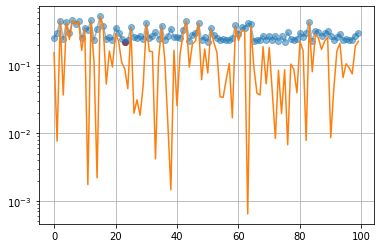

In [ ]:
df_res_hyperopt.loss.plot(style='-o', alpha=0.5)
plt.scatter([df_res_hyperopt.loss.argmin()], [df_res_hyperopt.loss.min()], c='r')
df_res_hyperopt.tr_loss.plot()
plt.yscale('log')
plt.grid()

Notamos que los mejores modelos encontrados por `hyperopt` sigue overfiteando. Observamos que el `traning_loss` es muy bajo en relación al `loss`. 

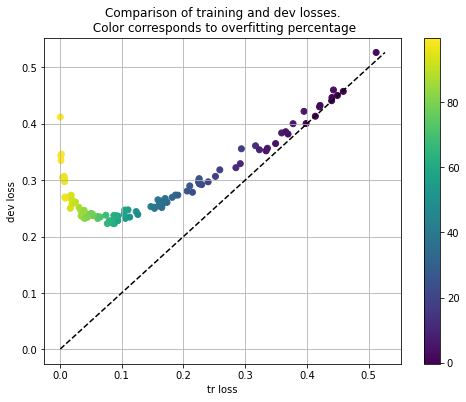

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(df_res_hyperopt.tr_loss, df_res_hyperopt.loss, c=(df_res_hyperopt.loss-df_res_hyperopt.tr_loss)/df_res_hyperopt.loss*100)
plt.title('Comparison of training and dev losses.\n Color corresponds to overfitting percentage')
plt.colorbar()
m = min(df_res_hyperopt.tr_loss.min(), df_res_hyperopt.loss.min())
M = max(df_res_hyperopt.tr_loss.max(), df_res_hyperopt.loss.max())
plt.plot([m, M], [m, M], 'k--')
plt.xlabel('tr loss')
plt.ylabel('dev loss')
plt.grid()

De este gráfico, notamos que los modelos que no overffitean tienen un performance similar al XGBoost y al baseline (`dev_loss` cercano al 0.3, 0.4). Considerando que esto no sería un buen modelo a usar.

**Hiperparámetros para XGBoost**

In [ ]:
import xgboost as xgb
from pprint import pprint
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from time import time


def objective(params):
    params['n_estimators'] = int(params['n_estimators'])
    print(params)
    pipe = make_pipeline(
      preprocessor1, 
      xgb.XGBClassifier(random_state=42, eval_metric='logloss', **params)
    )
    t0 = time()
    pipe.fit(xtrain, ytrain)
    train_time = time() - t0
    loss = log_loss(ydev, pipe.predict_proba(xdev)[:,1])
    print(f'loss {loss:.02f}')
    return dict(
        loss=loss,
        tr_loss=log_loss(ytrain, pipe.predict_proba(xtrain)[:,1]), 
        params=params,
        train_time=train_time,
        status=STATUS_OK
    )

space = {
    'n_estimators': hp.quniform('n_estimators', 10, 300, 10),
    'max_depth': hp.choice('max_depth', [1, 2, 3, 4, 5, 6]),
    'learning_rate': hp.qloguniform('learning_rate', np.log(0.01), np.log(0.3), 0.01),
    'gamma':  hp.qloguniform('gamma', np.log(0.01), np.log(100), 1),
    'subsample': hp.quniform('subsample', 0.3, 1.0, 0.1),
    'reg_alpha': hp.choice('ra', [0, hp.quniform('reg_alpha', 0.01, 0.1, 0.01)]),
    'scale_pos_weight': hp.choice('spw', [Counter(ytrain)[0]/Counter(ytrain)[1], math.sqrt(Counter(ytrain)[0]/Counter(ytrain)[1])])
}

trials = Trials()

In [ ]:
best = fmin(objective, space, algo=tpe.suggest, max_evals=100, trials=trials)

{'gamma': 14.0, 'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 250, 'reg_alpha': 0, 'scale_pos_weight': 4.420145748978314, 'subsample': 0.4}
loss 0.23
{'gamma': 0.0, 'learning_rate': 0.03, 'max_depth': 6, 'n_estimators': 270, 'reg_alpha': 0.06, 'scale_pos_weight': 19.537688442211056, 'subsample': 0.8}
loss 0.26
{'gamma': 40.0, 'learning_rate': 0.13, 'max_depth': 1, 'n_estimators': 190, 'reg_alpha': 0, 'scale_pos_weight': 4.420145748978314, 'subsample': 0.4}
loss 0.22
{'gamma': 0.0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 90, 'reg_alpha': 0, 'scale_pos_weight': 19.537688442211056, 'subsample': 0.9}
loss 0.51
{'gamma': 50.0, 'learning_rate': 0.03, 'max_depth': 4, 'n_estimators': 280, 'reg_alpha': 0.01, 'scale_pos_weight': 19.537688442211056, 'subsample': 0.7000000000000001}
loss 0.43
{'gamma': 6.0, 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 230, 'reg_alpha': 0.07, 'scale_pos_weight': 19.537688442211056, 'subsample': 0.30000000000000004}
loss 0.29
{'gamm

In [ ]:
def flatten(doc, pref=''):
    res = {}
    for k, v in doc.items():
        k = f'{pref}.{k}' if pref else k
        if isinstance(v, dict):
            res.update(flatten(v, k))
        else:
            res[k] = v
    return res


df_resXGB_hyperopt = pd.DataFrame(list(map(flatten, [e['result'] for e in trials.trials])))
df_resXGB_hyperopt.sort_values('loss').head()

,loss,tr_loss,params.gamma,params.learning_rate,params.max_depth,params.n_estimators,params.reg_alpha,params.scale_pos_weight,params.subsample,train_time,status
38,0.171238,0.086515,0.0,0.04,6,240,0.02,4.420146,0.4,1.299175,ok
39,0.172280,0.099419,0.0,0.03,6,260,0.02,4.420146,0.4,1.418516,ok
52,0.174221,0.098191,0.0,0.04,6,200,0.05,4.420146,0.4,1.091510,ok
94,0.175303,0.066986,0.0,0.05,6,240,0.00,4.420146,0.6,1.942439,ok
32,0.175439,0.046785,0.0,0.10,6,170,0.01,4.420146,0.6,1.004998,ok


In [ ]:
# para latex 
print(df_resXGB_hyperopt.sort_values('loss').head().to_latex(index=False))

\begin{tabular}{rrrrrrrrrrl}
\toprule
    loss &  tr\_loss &  params.gamma &  params.learning\_rate &  params.max\_depth &  params.n\_estimators &  params.reg\_alpha &  params.scale\_pos\_weight &  params.subsample &  train\_time & status \\
\midrule
0.171238 & 0.086515 &           0.0 &                  0.04 &                 6 &                  240 &              0.02 &                 4.420146 &               0.4 &    1.299175 &     ok \\
0.172280 & 0.099419 &           0.0 &                  0.03 &                 6 &                  260 &              0.02 &                 4.420146 &               0.4 &    1.418516 &     ok \\
0.174221 & 0.098191 &           0.0 &                  0.04 &                 6 &                  200 &              0.05 &                 4.420146 &               0.4 &    1.091510 &     ok \\
0.175303 & 0.066986 &           0.0 &                  0.05 &                 6 &                  240 &              0.00 &                 4.420146 &          

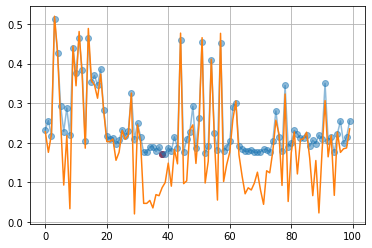

In [ ]:
df_resXGB_hyperopt.loss.plot(style='-o', alpha=0.5)
plt.scatter([df_resXGB_hyperopt.loss.argmin()], [df_resXGB_hyperopt.loss.min()], c='r')
df_resXGB_hyperopt.tr_loss.plot()
# plt.yscale('log')
plt.grid()

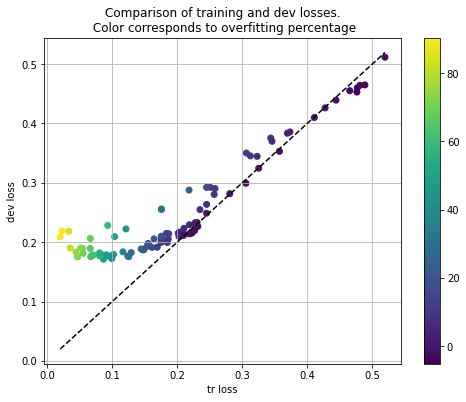

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(df_resXGB_hyperopt.tr_loss, df_resXGB_hyperopt.loss, c=(df_resXGB_hyperopt.loss-df_resXGB_hyperopt.tr_loss)/df_resXGB_hyperopt.loss*100)
plt.title('Comparison of training and dev losses.\n Color corresponds to overfitting percentage')
plt.colorbar()
m = min(df_resXGB_hyperopt.tr_loss.min(), df_resXGB_hyperopt.loss.min())
M = max(df_resXGB_hyperopt.tr_loss.max(), df_resXGB_hyperopt.loss.max())
plt.plot([m, M], [m, M], 'k--')
plt.xlabel('tr loss')
plt.ylabel('dev loss')
plt.grid()

Notamos que XGBoost optimizado funciona mejor que cualquier modelo anterior, además, podemos conseguir uno que no overfitte. Si tomamos los puntos cercanos a la recta de identidad, observamos que estos tienden a no overfitear y el error es menor. 

## II.2.&nbsp;Modelo candidato
Usaremos como candidato un modelo con error en train similar al error en dev, evitando de esta forma un modelo con problemas de overfitting. 

In [ ]:
best_xgb_pipe = make_pipeline(
    preprocessor1, 
    xgb.XGBClassifier(random_state=42, eval_metric='logloss', 
                      gamma= 0,
                      learning_rate= 0.04,
                      max_depht= 5,
                      n_estimators= 180,
                      reg_alpha= 0,
                      sale_pos_weight= 4,
                      subsample= 0.4)
  )

In [ ]:
# Modelo candidato a calibrar 
best_xgb = best_xgb_pipe.fit(xtrain, ytrain)

In [ ]:
dfRes1 = dfRes1.append(ev.eval_pipe('xgb con hyperopt', best_xgb_pipe) , ignore_index = True)

In [ ]:
# para latex
print(dfRes1.to_latex(index=False))

\begin{tabular}{lrr}
\toprule
                                name &    train &      dev \\
\midrule
                            baseline & 0.347787 & 0.443975 \\
                             solo lr & 0.499793 & 0.467997 \\
             lr con IterativeImputer & 0.499680 & 0.468944 \\
 lr con regresion de bmi y DTC en ss & 0.498566 & 0.468096 \\
                            solo lgb & 0.111823 & 0.249727 \\
     lgb con IterativeImputer de bmi & 0.156115 & 0.283055 \\
lgb con regresion de bmi y DTC en ss & 0.168947 & 0.293829 \\
                            solo xgb & 0.374278 & 0.400972 \\
     xgb con IterativeImputer de bmi & 0.386384 & 0.402270 \\
xgb con regresion de bmi y DTC en ss & 0.394658 & 0.409226 \\
                    xgb con hyperopt & 0.135736 & 0.160387 \\
\bottomrule
\end{tabular}



## II.3.&nbsp;Error analysis

In [ ]:
# Con el modelo entrenado, generamos predicciones 
# y calculamos el error por cada ejemplo

yhat_dev = best_xgb.predict_proba(xdev)[:,1]
ydev_array = np.asarray(ydev)
xdev_array = np.asarray(xdev)
err_dev = abs(ydev_array - yhat_dev)

In [ ]:
log_loss(ydev_array, yhat_dev) # sanity check, da el mismo que en la tabla

0.16038721253746416

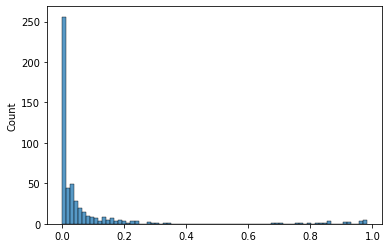

In [ ]:
sns.histplot(data=err_dev)

In [ ]:
# Ahora vamos a elegir los ejemplos donde más le pifiamos
bad_examples = [dict(x=e, y=ydev_array[i], y_hat=yhat_dev[i]) for i, e in enumerate(np.asarray(xdev)) if err_dev[i] > 0.7]

# Los que tienen mejor performance
good_examples = [dict(x=e, y=ydev_array[i], y_hat=yhat_dev[i]) for i, e in enumerate(np.asarray(xdev)) if err_dev[i] < 0.2]


In [ ]:
from random import sample
from IPython.display import display_markdown, display
pd.set_option('display.float_format', lambda x: '%.3f' % x)

def display_examples(examples, n=3):
  for i, ex in enumerate(sample(examples, n)):
    a = ex['x']
    display_markdown('#### dato {}'.format(i+1), raw=True)
    display(pd.DataFrame(a.reshape(-1, len(a)), columns=xdev.columns))
    display(pd.Series(dict(
        true_value=ex['y'], 
        predicted_value=ex['y_hat'],
        absolute_error=abs(ex['y'] - ex['y_hat']))))
    display_markdown('---', raw=True)

In [ ]:
display_examples(bad_examples, n=5)

#### dato 1

,gender,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,smoking_status
0,Male,74.000,1,1,Yes,70.090,27.400,never smoked


true_value        1.000
predicted_value   0.182
absolute_error    0.818
dtype: float64

---

#### dato 2

,gender,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,smoking_status
0,Male,71.000,1,0,Yes,87.800,NaN,Unknown


true_value        1.000
predicted_value   0.086
absolute_error    0.914
dtype: float64

---

#### dato 3

,gender,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,smoking_status
0,Male,57.000,1,0,Yes,78.920,27.700,formerly smoked


true_value        1.000
predicted_value   0.079
absolute_error    0.921
dtype: float64

---

#### dato 4

,gender,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,smoking_status
0,Female,65.000,0,0,Yes,100.980,28.200,formerly smoked


true_value        1.000
predicted_value   0.071
absolute_error    0.929
dtype: float64

---

#### dato 5

,gender,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,smoking_status
0,Female,45.000,0,0,Yes,93.720,30.200,formerly smoked


true_value        1.000
predicted_value   0.021
absolute_error    0.979
dtype: float64

---

In [ ]:
df_bad = pd.DataFrame([ e['x'] for e in bad_examples], columns=xdev.columns) 
df_bad['y'] = [ e['y'] for e in bad_examples]
df_good = pd.DataFrame([ e['x'] for e in good_examples], columns=xdev.columns) 
df_good['y'] = [ e['y'] for e in good_examples]

In [ ]:
df_good['y'].value_counts()

0    470
Name: y, dtype: int64

In [ ]:
df_bad['y'].value_counts()

1    22
Name: y, dtype: int64

Cuando el modelo se equivoca mucho, solo lo hace para casos con ACV (es esperable pues hay muy pocos casos de ACV). 

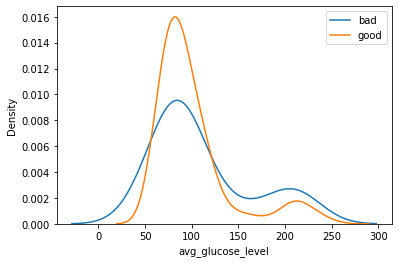

In [ ]:
sns.kdeplot(df_bad.avg_glucose_level, label="bad", common_norm=True)
sns.kdeplot(df_good.avg_glucose_level, label="good", common_norm=True)
plt.legend()

Pareciese que para `avg_glucose_level` pasado los 200 el modelo se equivoca más.

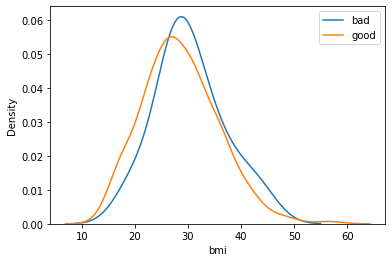

In [ ]:
sns.kdeplot(df_bad.bmi, label="bad")
sns.kdeplot(df_good.bmi, label="good")
plt.legend()

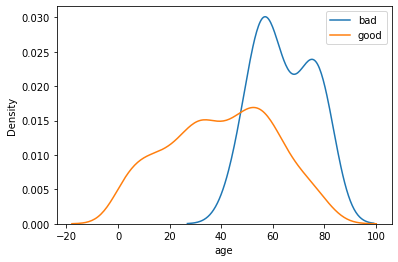

In [ ]:
sns.kdeplot(df_bad.age, label="bad")
sns.kdeplot(df_good.age, label="good")
plt.legend()

In [ ]:
len(bad_examples)/len(xdev)

0.043052837573385516

El modelo también tiende a errar mucho cuando la edad es alta. No obstante, esto representa solo el 4 % de los datos del dev. Consideramos que este error dificilmente se pueda mejorar dado el tamaño del dataset. 

## II.4.&nbsp; Análisis del poder clasificativo de los modelos
En esta sección, queremos ver qué tan bueno es nuestro modelo para distinguir las diferentes clases. Nos enfocaremos en un análisis cualitativo, graficando la distribución de las predicciones según la clase que pertenece. 

In [ ]:
def graficar_distribuciones(X, y, model, titulo=""): 
  # asegurarse de que el modelo este fitteado antes
  df = pd.DataFrame(
      {
      'predicho' : model.predict_proba(X)[:,1],
      'y_true' : y
       }
    )
  return sns.kdeplot(data=df, x='predicho', hue='y_true', common_norm= False, bw_method=0.1).set(title=titulo), df

**Logistic Regression**

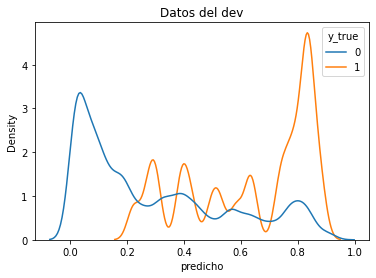

In [ ]:
fig1, data_lr = graficar_distribuciones(xdev, ydev, lr1, "Datos del dev")

**LigtGBM**

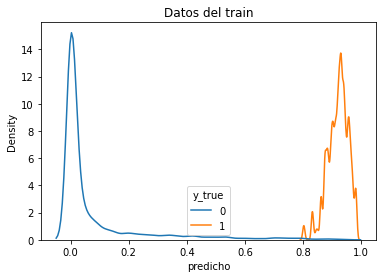

In [ ]:
fig2, data_lgb = graficar_distribuciones(xtrain, ytrain, lgb1, "Datos del train")

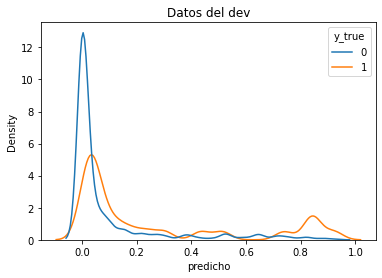

In [ ]:
fig2, data_lgb = graficar_distribuciones(xdev, ydev, lgb1, "Datos del dev")

Observamos que este modelo no clasifica bien, la densidad estimada de las predicciones para aquellos con ACV se acumula cerca del 0 y se parece a la densidad estimada de aquellos sin ACV. Nuevamente, esto nos indica que no sería una buena idea usar el LightGBM para nuestro problema. 

**XGBoost**

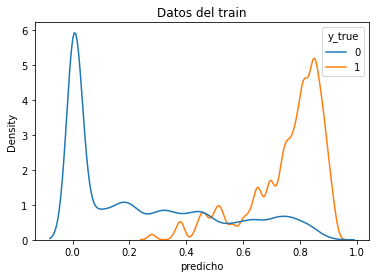

In [ ]:
fig3, data_xgb = graficar_distribuciones(xtrain, ytrain, xgb1, "Datos del train")

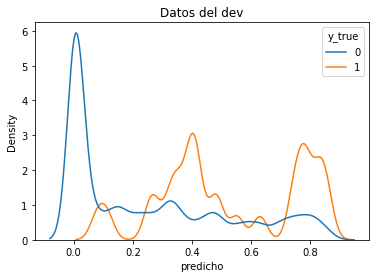

In [ ]:
fig3, data_xgb = graficar_distribuciones(xdev, ydev, xgb1, "Datos del dev")

**Best XGBoost**

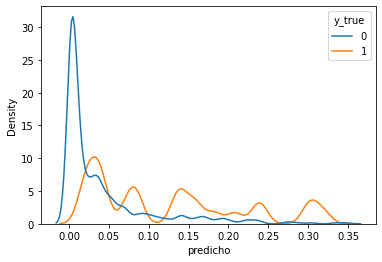

In [ ]:
fig4, data_xgb = graficar_distribuciones(xdev, ydev, best_xgb_pipe)

# III. Calibración de probabilidad para los modelos

In [ ]:
from sklearn.calibration import CalibratedClassifierCV
# fit and calibrate model on training data
calibrator = CalibratedClassifierCV(lr1, method="isotonic", cv=5)

In [ ]:
best_xgb

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer())]),
                                                  ['bmi']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['age', 'avg_glucose_level']),
                                                 ('pipeline-3',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder())]),
                                                  ['gender', 'ever_married',
                                                   'smoking_status',
                                                   'heart_disease',
                                                   'hypertension'])])),
                ('xgbclassifier',
                 XGBClassifier(eval_metric='logloss', learning_rate=0.04,
                               max_depht=5, n_estimators=180, random_state=42,
                               sale_pos_weight=4, subsample=0.4))])

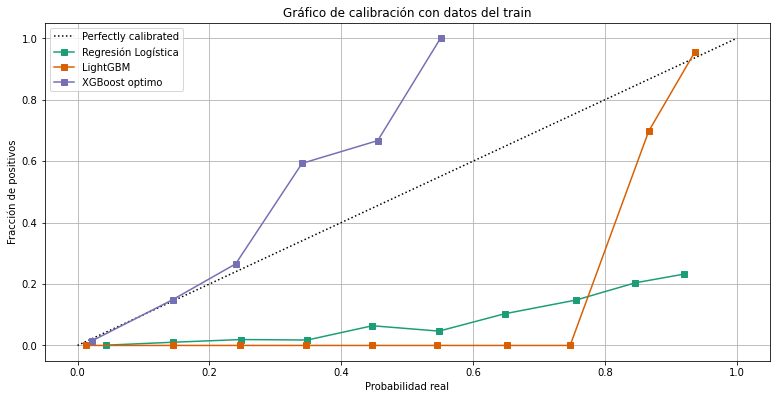

In [ ]:
from sklearn.calibration import CalibrationDisplay
clf_list = [
    (lr1, "Regresión Logística"),
    (lgb1, "LightGBM"),
    (best_xgb, "XGBoost optimo")
]

from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(13, 13))
gs = GridSpec(4, 2)
colors = plt.cm.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (clf, name) in enumerate(clf_list):
    # clf.fit(xtrain, ytrain),
    preds = clf.predict_proba(xtrain)[:,1]
    display = CalibrationDisplay.from_predictions(
        # clf,
        # xdev,
        ytrain,
        preds,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Gráfico de calibración con datos del train")
ax_calibration_curve.set_xlabel("Probabilidad real")
ax_calibration_curve.set_ylabel("Fracción de positivos")
ax_calibration_curve.legend(loc="upper left")

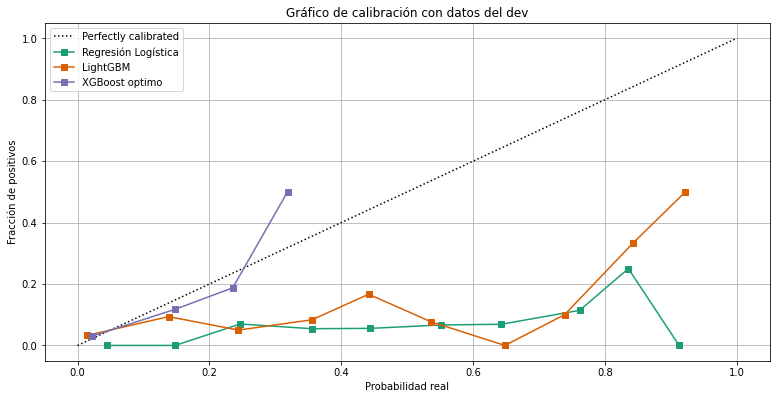

In [ ]:
fig = plt.figure(figsize=(13, 13))
gs = GridSpec(4, 2)
colors = plt.cm.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (clf, name) in enumerate(clf_list):
    # clf.fit(xtrain, ytrain),
    preds = clf.predict_proba(xdev)[:,1]
    display = CalibrationDisplay.from_predictions(
        # clf,
        # xdev,
        ydev,
        preds,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Gráfico de calibración con datos del dev")
ax_calibration_curve.set_xlabel("Probabilidad real")
ax_calibration_curve.set_ylabel("Fracción de positivos")
ax_calibration_curve.legend(loc="upper left")

In [ ]:
def dameProbaReal(predicho, real,scorePuntual, ventana):
  df= pd.DataFrame(
    {
      'predicho' : predicho,
     'real' : real
    }
  )
  df2 = df[df['predicho'] > scorePuntual - ventana ]
  df2 = df2[df2['predicho'] < scorePuntual + ventana ]
  return(np.mean(df2["real"]))

In [ ]:
def dameColumnaReales(predicho, real, ventana):
  probas = np.zeros(len(predicho))
  for i in range(0, len(probas)):
    probas[i] = dameProbaReal(predicho, real, predicho[i], ventana)
  return probas

In [ ]:
def predictProbas(pipe, xtrain, xdev, xtest):
  predtrain = pipe.predict_proba(xtrain)[:,1]
  preddev = pipe.predict_proba(xdev)[:,1]
  predtest = pipe.predict_proba(xtest)[:,1]
  return(predtrain,preddev,predtest)
  

In [ ]:
def armarXsupermodelo(predxtrain, predxdev,predxtest):
  xSuperModeloStacktrain = []
  xSuperModeloStackdev= []
  xSuperModeloStackTest = []
  for i in range(0,len(predxtrain)): # Decidimos hacer el modelo de ajuste cuadratico porque era el mas simple que mejor ajustaba
    xSuperModeloStacktrain.append([1,predxtrain[i],predxtrain[i]**2])
  for i in range(0,len(predxdev)):
    xSuperModeloStackdev.append([1,predxdev[i],predxdev[i]**2])
  for i in range(0,len(predxtest)):
    xSuperModeloStackTest.append([1,predxtest[i],predxtest[i]**2])
  return (xSuperModeloStacktrain,xSuperModeloStackdev, xSuperModeloStackTest )

In [ ]:
(ptr,pde, pte) = predictProbas(best_xgb, xtrain, xdev, xtest)

In [ ]:
(suptr,supd, supte) = armarXsupermodelo(ptr, pde, pte)

In [ ]:
predlrtrain = lr1.predict_proba(xtrain)[:,1]
predlrdev = lr1.predict_proba(xdev)[:,1]
predlrtest = lr1.predict_proba(xtest)[:,1]
predlgb1train = lgb1.predict_proba(xtrain)[:,1]
predlgb1dev = lgb1.predict_proba(xdev)[:,1]
predlgb1test = lgb1.predict_proba(xtest)[:,1]

In [ ]:
xSuperModeloStacktrain = []
xSuperModeloStackdev = []
xSuperModeloStackTest = []
xSuperModeloStacktrainLGB = []
xSuperModeloStackdevLGB = []
xSuperModeloStackTestLGB = []
for i in range(0,len(predlrtrain)): # Decidimos hacer el modelo de ajuste cuadratico porque era el mas simple que mejor ajustaba
  xSuperModeloStacktrain.append([1,predlrtrain[i],predlrtrain[i]**2])
  xSuperModeloStacktrainLGB.append([1,predlgb1train[i],predlgb1train[i]**2])
for i in range(0,len(predlrdev)):
  xSuperModeloStackdev.append([1,predlrdev[i],predlrdev[i]**2])
  xSuperModeloStackdevLGB.append([1,predlgb1dev[i],predlgb1dev[i]**2])
for i in range(0,len(predlrtest)):
  xSuperModeloStackTest.append([1,predlrtest[i],predlrtest[i]**2])
  xSuperModeloStackTestLGB.append([1,predlgb1test[i],predlgb1test[i]**2])

Importante, no estamos calibrando con Train, despues de hablarlo con una experta en el asunto de calibracion nos recomendo hacer la calibracion de nuestro modelo que toma scores en OTRO set de datos, tipo dev, luego habra que evaluarlo en un dev distinto.

In [ ]:
superModelo = Ridge().fit(xSuperModeloStackdev, ydev) #CALIBRACION EN DEV
superModeloLGB = Ridge().fit(xSuperModeloStackdevLGB, ydev) #CALIBRACION EN DEV
superModeloXGB = Ridge().fit(supd, ydev) #CALIBRACION EN DEV
coef = superModelo.coef_
coeflgb = superModeloLGB.coef_
coefxgb = superModeloXGB.coef_


Visualizacion de la calibracion

In [ ]:
xsModelo = np.linspace(0,1,100)
ysModelo = list(map(lambda x: coef[0] + x*coef[1] + (x**2) *coef[2], xsModelo)) 
ysModeloLGB = list(map(lambda x: coeflgb[0] + x*coeflgb[1] + (x**2) *coeflgb[2], xsModelo))
ysModeloXGB = list(map(lambda x: coefxgb[0] + x*coefxgb[1] + (x**2) *coefxgb[2], xsModelo)) 

Text(0, 0.5, 'nueva score')

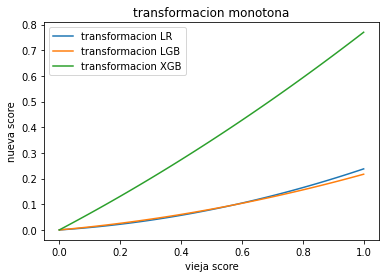

In [ ]:
plt.plot(xsModelo, ysModelo, label="transformacion LR")
plt.legend()
plt.plot(xsModelo, ysModeloLGB, label="transformacion LGB")
plt.legend()
plt.plot(xsModelo, ysModeloXGB, label="transformacion XGB")
plt.legend()
plt.title("transformacion monotona") # (preserva ordenes)
plt.xlabel("vieja score")
plt.ylabel("nueva score")

Comparaciones con calibrado

In [ ]:
probasRealesTrainLr = dameColumnaReales(predlrtrain, ytrain, 0.1)
probasRealesDevLr = dameColumnaReales(predlrdev, ydev, 0.1)
probasRealesTestLr = dameColumnaReales(predlrtest, ytest, 0.1)

probasRealesTrainLGB = dameColumnaReales(predlgb1train, ytrain, 0.1)
probasRealesDevLGB = dameColumnaReales(predlgb1dev, ydev, 0.1)
probasRealesTestLGB = dameColumnaReales(predlgb1test, ytest, 0.1)

In [ ]:
probasRealesTrainXGB = dameColumnaReales(ptr, ytrain, 0.1)
probasRealesDevXGB = dameColumnaReales(pde, ydev, 0.1)
probasRealesTestXGB = dameColumnaReales(pte, ytest, 0.1)

In [ ]:
predSupertrain = superModelo.predict(xSuperModeloStacktrain)
predSuperdev = superModelo.predict(xSuperModeloStackdev)
predSuperTest = superModelo.predict(xSuperModeloStackTest)

predSupertrainLGB = superModeloLGB.predict(xSuperModeloStacktrainLGB)
predSuperdevLGB = superModeloLGB.predict(xSuperModeloStackdevLGB)
predSuperTestLGB = superModeloLGB.predict(xSuperModeloStackTestLGB)


predSupertrainXGB = superModeloXGB.predict(suptr)
predSuperdevXGB = superModeloXGB.predict(supd)
predSuperTestXGB = superModeloXGB.predict(supte)

In [ ]:
probasRealesTrainLrTransformado = dameColumnaReales(predSupertrain, ytrain, 0.1)
probasRealesDevLrTransformado = dameColumnaReales(predSuperdev, ydev, 0.1)
probasRealesTestLrTransformado = dameColumnaReales(predSuperTest, ytest, 0.1)

probasRealesTrainLGBTransformado = dameColumnaReales(predSupertrainLGB, ytrain, 0.1)
probasRealesDevLGBTransformado = dameColumnaReales(predSuperdevLGB, ydev, 0.1)
probasRealesTestLGBTransformado = dameColumnaReales(predSuperTestLGB, ytest, 0.1)

probasRealesTrainXGBTransformado = dameColumnaReales(predSupertrainXGB, ytrain, 0.1)
probasRealesDevXGBTransformado = dameColumnaReales(predSuperdevXGB, ydev, 0.1)
probasRealesTestXGBTransformado = dameColumnaReales(predSuperTestXGB, ytest, 0.1)

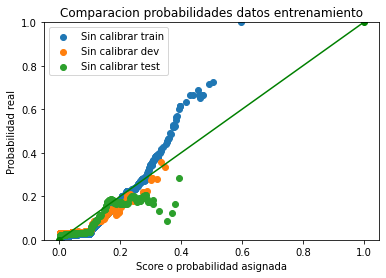

In [ ]:
plt.plot([0,1],[0,1], 'go-')
plt.ylim([0,1])
plt.scatter(ptr, probasRealesTrainXGB, label="Sin calibrar train")
plt.legend()
plt.scatter(pde, probasRealesDevXGB, label="Sin calibrar dev")
plt.legend()
plt.scatter(pte, probasRealesTestXGB, label="Sin calibrar test")
plt.legend()
plt.ylabel("Probabilidad real")
plt.xlabel("Score o probabilidad asignada")
plt.title("Comparacion probabilidades datos entrenamiento")
plt.show()

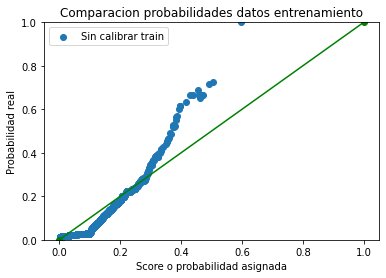

In [ ]:
plt.plot([0,1],[0,1], 'go-')
plt.ylim([0,1])
plt.scatter(ptr, probasRealesTrainXGB, label="Sin calibrar train")
plt.legend()

#plt.scatter(predSupertrainXGB, probasRealesTrainXGBTransformado, label="XGB luego de calibrar train (con dev)")
plt.legend()
plt.ylabel("Probabilidad real")
plt.xlabel("Score o probabilidad asignada")
plt.title("Comparacion probabilidades datos entrenamiento")
plt.show()

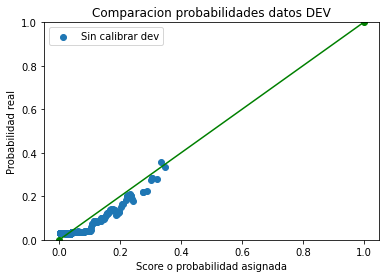

In [ ]:
plt.plot([0,1],[0,1], 'go-')
plt.ylim([0,1])
plt.scatter(pde, probasRealesDevXGB, label="Sin calibrar dev")
plt.legend()
#plt.scatter(predSuperdevXGB, probasRealesDevXGBTransformado, label="XGB luego de calibrar dev (con dev)")
plt.legend()
plt.ylabel("Probabilidad real")
plt.xlabel("Score o probabilidad asignada")
plt.title("Comparacion probabilidades datos DEV")
plt.show()

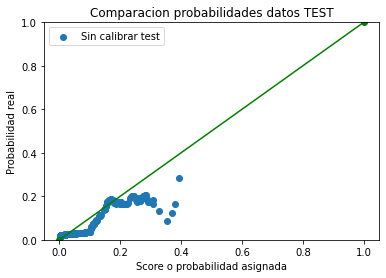

In [ ]:
plt.plot([0,1],[0,1], 'go-')
plt.ylim([0,1])
plt.scatter(pte, probasRealesTestXGB, label="Sin calibrar test")
plt.legend()
#plt.scatter(predSuperTestXGB, probasRealesTestXGBTransformado, label="XGB luego de calibrar test (con dev)")
plt.legend()
plt.ylabel("Probabilidad real")
plt.xlabel("Score o probabilidad asignada")
plt.title("Comparacion probabilidades datos TEST")
plt.show()

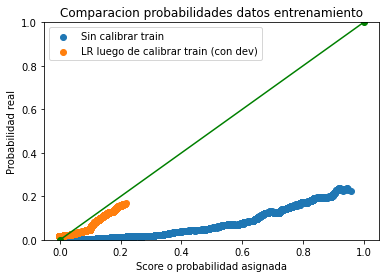

In [ ]:
plt.plot([0,1],[0,1], 'go-')
plt.ylim([0,1])
plt.scatter(lr1.predict_proba(xtrain)[:,1], probasRealesTrainLr, label="Sin calibrar train")
plt.legend()
plt.scatter(predSupertrain, probasRealesTrainLrTransformado, label="LR luego de calibrar train (con dev)")
plt.legend()
plt.ylabel("Probabilidad real")
plt.xlabel("Score o probabilidad asignada")
plt.title("Comparacion probabilidades datos entrenamiento")
plt.show()

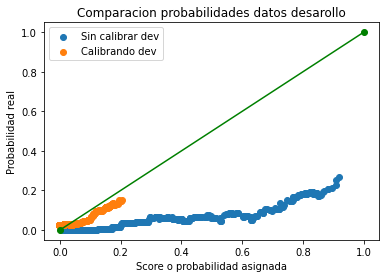

In [ ]:
plt.plot([0,1],[0,1], 'go-')
plt.scatter(lr1.predict_proba(xdev)[:,1], probasRealesDevLr, label="Sin calibrar dev")
plt.legend()
plt.scatter(predSuperdev, probasRealesDevLrTransformado, label="Calibrando dev")
plt.legend()
plt.title("Comparacion probabilidades datos desarollo")

plt.ylabel("Probabilidad real")
plt.xlabel("Score o probabilidad asignada")

plt.show()

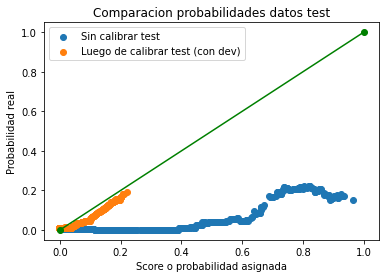

In [ ]:
plt.plot([0,1],[0,1], 'go-')
plt.scatter(lr1.predict_proba(xtest)[:,1], probasRealesTestLr, label="Sin calibrar test")
plt.legend()
plt.scatter(predSuperTest, probasRealesTestLrTransformado, label="Luego de calibrar test (con dev)")
plt.legend()
plt.title("Comparacion probabilidades datos test")

plt.ylabel("Probabilidad real")
plt.xlabel("Score o probabilidad asignada")

plt.show()

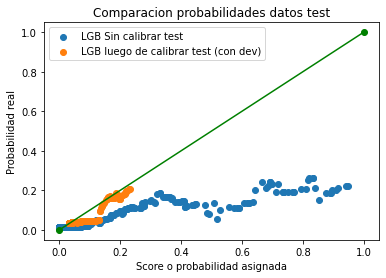

In [ ]:
plt.plot([0,1],[0,1], 'go-')
plt.scatter(predlgb1test, probasRealesTestLGB, label="LGB Sin calibrar test")
plt.legend()
plt.scatter(predSuperTestLGB, probasRealesTestLGBTransformado, label="LGB luego de calibrar test (con dev)")
plt.legend()
plt.title("Comparacion probabilidades datos test")

plt.ylabel("Probabilidad real")
plt.xlabel("Score o probabilidad asignada")

plt.show()

In [ ]:
df_testScoresTransformados= pd.DataFrame(
    {
      'predicho' : predSuperTest,
     'ytest' : ytest
    }
)
df_testScoresTransformadosLGB= pd.DataFrame(
    {
      'predicho' : predSuperTestLGB,
     'ytest' : ytest
    }
)

([Text(0.5, 1.0, '')],       predicho  y_true
 2888     0.396       0
 680      0.105       0
 4260     0.484       0
 2164     0.463       0
 4956     0.346       0
 ...        ...     ...
 1070     0.893       0
 4375     0.829       0
 1758     0.012       0
 3364     0.219       0
 4225     0.150       0
 
 [511 rows x 2 columns])

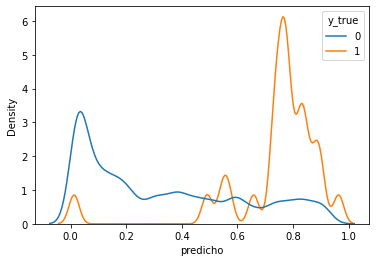

In [ ]:
graficar_distribuciones(xtest, ytest, lr1)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


[Text(0.5, 1.0, 'LR Distribucion de scores calibradas')]

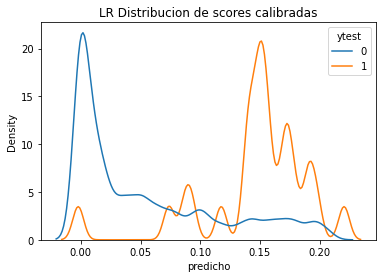

In [ ]:
sns.kdeplot(data=df_testScoresTransformados, x='predicho', hue='ytest', common_norm= False, bw=0.1).set(title='LR Distribucion de scores calibradas')


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


[Text(0.5, 1.0, 'LGB Distribucion de scores calibradas')]

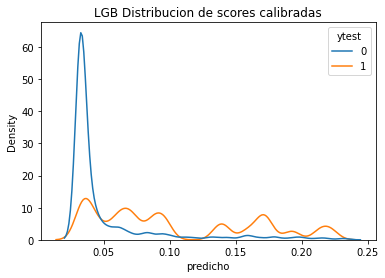

In [ ]:
sns.kdeplot(data=df_testScoresTransformadosLGB, x='predicho', hue='ytest', common_norm= False, bw=0.1).set(title='LGB Distribucion de scores calibradas')


In [ ]:
errorTrainSinTransf  = log_loss(ytrain, lr1.predict_proba(xtrain)[:,1], )
errorTrainTransf  = log_loss(ytrain, predSupertrain, )

errorDevSinTransf  = log_loss(ydev, lr1.predict_proba(xdev)[:,1], )
errorDevTransf  = log_loss(ydev, predSuperdev, )

errorTestSinTransf  = log_loss(ytest, predlrtest, )
errorTestTransf  = log_loss(ytest, predSuperTest, )

In [ ]:
d = {"": ["Train", "Dev", "Test"], 
     "Sin calibrar": [errorTrainSinTransf, errorDevSinTransf, errorTestSinTransf],
     "Calibrando": [errorTrainTransf, errorDevTransf, errorTestTransf]
     }
dfErroresComparacionCalibracion = pd.DataFrame.from_dict(d)

In [ ]:
dfErroresComparacionCalibracion

,,Sin calibrar,Calibrando
0,Train,0.500,0.162
1,Dev,0.468,0.159
2,Test,0.541,0.211


In [ ]:
# para latex
print(dfErroresComparacionCalibracion.to_latex(index=False))

\begin{tabular}{lrr}
\toprule
      &  Sin calibrar &  Calibrando \\
\midrule
Train &         0.500 &       0.162 \\
  Dev &         0.468 &       0.159 \\
 Test &         0.541 &       0.211 \\
\bottomrule
\end{tabular}



In [ ]:
errorTrainSinTransfXGB  = log_loss(ytrain, ptr, )
errorTrainTransfXGB  = log_loss(ytrain, predSupertrainXGB, )

errorDevSinTransfXGB  = log_loss(ydev, pde, )
errorDevTransfXGB  = log_loss(ydev, predSuperdevXGB, )

errorTestSinTransfXGB  = log_loss(ytest, pte, )
errorTestTransfXGB  = log_loss(ytest, predSuperTestXGB, )

In [ ]:
d2 = {"": ["Train", "Dev", "Test"], 
     "Sin calibrar_XGB ": [errorTrainSinTransfXGB, errorDevSinTransfXGB, errorTestSinTransfXGB],
     "Calibrando_XGB ": [errorTrainTransfXGB, errorDevTransfXGB, errorTestTransfXGB]
     }
dfErroresComparacionCalibracionXGB = pd.DataFrame.from_dict(d2)

In [ ]:
dfErroresComparacionCalibracionXGB

,,Sin calibrar_XGB,Calibrando_XGB
0,Train,0.136,0.149
1,Dev,0.160,0.168
2,Test,0.150,0.160


In [ ]:
# para latex
print(dfErroresComparacionCalibracionXGB.to_latex(index=False))

\begin{tabular}{lrr}
\toprule
      &  Sin calibrar\_XGB  &  Calibrando\_XGB  \\
\midrule
Train &              0.136 &            0.149 \\
  Dev &              0.160 &            0.168 \\
 Test &              0.150 &            0.160 \\
\bottomrule
\end{tabular}



# IV. Selección del modelo final y conclusión
Como modelo final tenemos el XGBoost sin calibrar, dado que tiene un error en test de 0.15 y es realtivamente robusto. Además, de entre todos los otros modelos es aquel con menor error. 

In [ ]:
ev_final = Evaluator(xtrain, ytrain, xdev, ydev, xtest, ytest)

ev_final.eval_pipe('solo lr', lr1_pipe)
ev_final.eval_pipe('solo lgb', lgb1_pipe)
ev_final.eval_pipe('solo xgb', xgb1_pipe)
ev_final.eval_pipe('xgb + hyperopt', best_xgb_pipe)
df_results = pd.DataFrame(ev_final.evaluations)
df_results = df1.append(df_results, ignore_index = True)

In [ ]:
print(df_results.to_latex(index=False))

\begin{tabular}{lrrr}
\toprule
          name &  train &   dev &  test \\
\midrule
      baseline &  0.348 & 0.444 &   NaN \\
       solo lr &  0.500 & 0.468 & 0.541 \\
      solo lgb &  0.112 & 0.250 & 0.248 \\
      solo xgb &  0.374 & 0.401 & 0.441 \\
xgb + hyperopt &  0.136 & 0.160 & 0.150 \\
\bottomrule
\end{tabular}

